In [67]:
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install pandas
%pip install tabulate

from numpy import random as rd
import numpy as np
from typing import List, Callable, Tuple
import matplotlib.pyplot as plt
import math

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Definindo comportamento

## Individuo

In [68]:
class Individuo():
    def __init__(self,
                 genotipo: List[float],
                 fn_objetivo: Callable,
                 fabric_fn_mutacao: Callable,
                 mutation_rate: float = 0.1,
                 constrains: List[Callable[[List[float]], bool]] = [],
                 is_minimization: bool = True):
        self.genotipo = genotipo
        self.fenotipo = None
        self.fn_objetivo = fn_objetivo
        self.fn_mutacao = fabric_fn_mutacao(mutation_rate)
        self.fabric_fn_mutacao = fabric_fn_mutacao
        self.constrains = constrains
        self.is_minimization = is_minimization

    def get_fenotipo(self) -> float:
        if self.fenotipo == None:
            for constrain in self.constrains:
                if not constrain(*self.genotipo):
                    # Se não estiver de acordo com as restrições, retorna infinito positivo para minimização e infinito negativo para maximização
                    self.fenotipo = math.inf if self.is_minimization else -math.inf
                    return self.fenotipo
            # Se chego aqui, está de acordo com as restrições
            self.fenotipo = self.fn_objetivo(*self.genotipo)
            return self.fenotipo
        else:
            return self.fenotipo

    def reproduzir_assexuado(self, quant_filhos: int = 1) -> List['Individuo']:
        filhos = []
        for _ in range(quant_filhos):
            genotipo_mutado: List[float] = self.fn_mutacao(self.genotipo)
            filhos.append(Individuo(genotipo_mutado,
                                    self.fn_objetivo, self.fabric_fn_mutacao))
        return filhos

    def reproduzir_sexuado(self, outro: 'Individuo', quant_filhos: int = 1) -> List['Individuo']:
        filhos = []
        for _ in range(quant_filhos):

            genotipo_mutado: List[float] = self.fn_mutacao(
                self.genotipo, outro.genotipo)
            filhos.append(Individuo(genotipo_mutado,
                                    self.fn_objetivo, self.fabric_fn_mutacao))

        return filhos

    def __str__(self) -> str:
        return f"({self.genotipo}, {self.get_fenotipo()})"

    def __lt__(self, obj):
        return ((self.get_fenotipo()) < (obj.get_fenotipo()))

    def __gt__(self, obj):
        return ((self.get_fenotipo()) > (obj.get_fenotipo()))

    def __le__(self, obj):
        return ((self.get_fenotipo()) <= (obj.get_fenotipo()))

    def __ge__(self, obj):
        return ((self.get_fenotipo()) >= (obj.get_fenotipo()))

    def __eq__(self, obj):
        return (self.get_fenotipo() == obj.get_fenotipo())

## População

In [69]:
class Populacao():
    def __init__(self,
                 quant_pais: int,
                 fn_objetivo: Callable[..., float],
                 fabric_fn_mutacao: Callable[[float], Callable[[List[float]], List[float]]],
                 quant_parametros_fn_objetivo: int = 1,
                 is_minimization: bool = True,
                 lim_inf: List[float] = [-math.inf],
                 lim_sup: List[float] = [math.inf],
                 quant_filhos: int = -1,
                 constrains: List[Callable[[List[float]], bool]] = []
                 ):
        self.individuos: List[Individuo] = []
        for _ in range(quant_pais):
            genotipo: List[float] = [rd.uniform(
                lim_inf[i], lim_sup[i]) for i in range(quant_parametros_fn_objetivo)]

            novo_individuo = Individuo(genotipo=genotipo,
                                       fn_objetivo=fn_objetivo,
                                       fabric_fn_mutacao=fabric_fn_mutacao,
                                       is_minimization=is_minimization,
                                       constrains=constrains
                                       )
            self.individuos.append(novo_individuo)

        self.__quant_pais = quant_pais
        self.__quant_filhos = quant_filhos if quant_filhos > 0 else quant_pais
        self.is_minimization = is_minimization
        self.quant_geracoes = 0

    def sexo_descontrolado_sozinho(self):
        """
        Realiza reprodução assexuada de indivíduos selecionados aleatoriamente.

        Esta função seleciona aleatoriamente um indivíduo existente na população e realiza
        a reprodução assexuada do mesmo para gerar um número específico de filhos. Os filhos
        são adicionados à população existente.

        Parâmetros:
        - self: A instância da classe que invoca o método.

        Retorna:
        - Nenhum valor de retorno.

        Mutações no estado do objeto:
        - A lista de indivíduos é ampliada para incluir os novos filhos.
        """
        filhos: List[Individuo] = []
        for _ in range(self.__quant_filhos):
            pai = self.individuos[rd.randint(0, len(self.individuos))]
            filhos.extend(pai.reproduzir_assexuado())
        self.individuos.extend(filhos)

    def sexo_descontrolado(self):
        """
        Realiza reprodução sexuada de indivíduos selecionados aleatoriamente.

        Esta função seleciona aleatoriamente dois indivíduos existentes na população e realiza
        a reprodução sexuada dos mesmos para gerar um número específico de filhos. Os filhos
        são adicionados à população existente.

        Parâmetros:
        - self: A instância da classe que invoca o método.

        Retorna:
        - Nenhum valor de retorno.

        Mutações no estado do objeto:
        - A lista de indivíduos é ampliada para incluir os novos filhos.
        """
        filhos: List[Individuo] = []
        for _ in range(self.__quant_filhos):
            pai = self.individuos[rd.randint(0, len(self.individuos))]
            mae = self.individuos[rd.randint(0, len(self.individuos))]
            filhos.extend(mae.reproduzir_sexuado(pai))
        self.individuos.extend(filhos)

    def matar_os_fracos(self):
        """
        Remove os indivíduos mais fracos da população.

        A função ordena a lista de indivíduos e remove os indivíduos mais fracos,
        mantendo apenas os melhores indivíduos de acordo com a quantidade de pais
        definida.

        Se a função de avaliação for de minimização, os primeiros self.__quant_pais
        individuos da lista ordenada (por fenótipo) são selecionados, caso contrário,
        o mesmo acontecerá pegando do final da lista.

        Parâmetros:
        - self: referência ao objeto da classe

        Retorno:
        - None

        Mutações no estado do objeto:
        - A lista de indivíduos é reduzida para o tamanho original de modo a 
        conter apenas os melhores indivíduos dessa geração.
        """
        self.individuos.sort(reverse=not self.is_minimization)
        self.individuos = self.individuos[:self.__quant_pais]

    def melhor_individuo(self) -> Individuo:
        return sorted(self.individuos)[0] if self.is_minimization else sorted(self.individuos)[-1]

    def individuo_medio(self) -> Individuo:
        return sorted(self.individuos)[math.floor(self.__quant_pais / 2)]

    def selecionar_melhor(self, individuos: List[Individuo]) -> Individuo:
        return sorted(individuos)[0] if self.is_minimization else sorted(individuos)[-1]

    def selecionar_medio(self, individuos: List[Individuo]) -> Individuo:
        return sorted(individuos)[math.floor(len(individuos) / 2)]

    def __str__(self):
        r = "População:\n"
        for individuo in self.individuos:
            r += individuo.__str__() + ", "
        return r

# Problema 1:

maximizar f (x) = xsin 10πx+ 1  
sujeito a: −1 ≤x ≤2

## Gerando população

In [70]:
def evoluir(quantidade_geracoes: int, pop: Populacao) -> Tuple[Individuo, Individuo]:
    melhores_de_cada_geracao: List[Individuo] = []
    pau_medio: List[Individuo] = []

    for _ in range(quantidade_geracoes):
        pop.sexo_descontrolado_sozinho()
        pop.matar_os_fracos()
        melhores_de_cada_geracao.append(pop.melhor_individuo())
        pau_medio.append(pop.individuo_medio())

    return (pop.selecionar_melhor(melhores_de_cada_geracao), pop.selecionar_medio(pau_medio))


def fabric_fn_mutacao(mutation_rate: float) -> Callable:
    def fn_mutacao(genotipo: List[float]) -> List[float]:
        return [g + rd.uniform(-mutation_rate, mutation_rate) for g in genotipo]
    return fn_mutacao


def new_exp(quant_pais: int = 100, quant_filhos: int = 100) -> Populacao:

    return Populacao(quant_pais=quant_pais,
                     quant_filhos=quant_filhos,
                     fn_objetivo=(lambda x: x*np.sin(10*3.14*x) + 1),
                     fabric_fn_mutacao=fabric_fn_mutacao,
                     is_minimization=False,
                     lim_inf=[-1], lim_sup=[2]
                     )


# Assuming evoluir function and new_exp function are defined correctly

results: List[Tuple[int, int, int, Tuple[Individuo, Individuo]]] = []
for quantidade_geracoes in range(10, 110, 10):
    for quant_pais in range(10, 110, 10):
        for quant_filhos in range(10, 110, 10):
            pop = new_exp(quant_pais, quant_filhos)  # Create the population
            # Evolve and get the best and average
            best, avg = evoluir(quantidade_geracoes, pop)
            # Append the results with the structure including the parameters
            results.append(
                (quantidade_geracoes, quant_pais, quant_filhos, (best, avg)))

## Mostrando tabela solicitada

In [71]:
from tabulate import tabulate

data = []

for entry in results:
    quantidade_geracoes, quant_pais, quant_filhos, (
        best_individuo, avg_individuo) = entry
    row = [
        quantidade_geracoes,  # Number of generations
        quant_pais,            # Number of parents
        quant_filhos,          # Number of children
        best_individuo.genotipo[0],  # list of parameters of the best individuo
        best_individuo.get_fenotipo(),  # f(x) of the best individuo
        avg_individuo.genotipo[0],   # list of parameters of the average individuo
        avg_individuo.get_fenotipo(),   # f(x) of the average individuo
    ]
    data.append(row)

# Define headers for your new columns
headers = ["tmax", "μ", "λ", "best x", 
           "best f(x)", "avg x", "avg f(x)"]

# Print the table using tabulate
table = tabulate(data, 
                 headers=headers, 
                 tablefmt="github", 
                 floatfmt=".4f"
                 )
print(table)

|   tmax |   μ |   λ |   best x |   best f(x) |   avg x |   avg f(x) |
|--------|-----|-----|----------|-------------|---------|------------|
|     10 |  10 |  10 |   1.6505 |      2.6504 |  1.2550 |     2.2430 |
|     10 |  10 |  20 |   1.6495 |      2.6479 |  1.6456 |     2.6232 |
|     10 |  10 |  30 |   1.2511 |      2.2510 |  1.2459 |     2.2320 |
|     10 |  10 |  40 |   1.6515 |      2.6511 |  1.6489 |     2.6459 |
|     10 |  10 |  50 |   1.4511 |      2.4510 |  1.4491 |     2.4473 |
|     10 |  10 |  60 |   1.8515 |      2.8512 |  1.8529 |     2.8495 |
|     10 |  10 |  70 |   1.8516 |      2.8512 |  1.8523 |     2.8506 |
|     10 |  10 |  80 |   1.8516 |      2.8512 |  1.8506 |     2.8504 |
|     10 |  10 |  90 |   1.4513 |      2.4511 |  1.4525 |     2.4503 |
|     10 |  10 | 100 |   2.0517 |      3.0513 |  2.0524 |     3.0506 |
|     10 |  20 |  10 |   1.8434 |      2.7917 |  1.6815 |     1.9623 |
|     10 |  20 |  20 |   2.0538 |      3.0459 |  1.2776 |     1.8451 |
|     

## Plotando

### Criando o data frame

In [72]:
import pandas as pd

data = []

for (quantidade_geracoes, quant_pais, quant_filhos, (best_individuo, avg_individuo)) in results:
    data.append({
        'Quantidade Gerações': quantidade_geracoes,
        'Quant Pais': quant_pais,
        'Quant Filhos': quant_filhos,
        # Assuming this is accessible and meaningful (e.g., a list or tuple of parameters)
        'Best Genotipo': best_individuo.genotipo,
        'Best Fitness': best_individuo.get_fenotipo(),
        # Similarly, assuming this is a list or tuple
        'Average Genotipo': avg_individuo.genotipo,
        'Average Fitness': avg_individuo.get_fenotipo()
    })

df = pd.DataFrame(data)

df[['Best x']] = pd.DataFrame(
    df['Best Genotipo'].tolist(), index=df.index)

df[['Avg x']] = pd.DataFrame(
    df['Average Genotipo'].tolist(), index=df.index)

df.drop(['Best Genotipo', 'Average Genotipo'], axis=1, inplace=True)

# Display the first few rows to verify
print(df.head())

   Quantidade Gerações  Quant Pais  Quant Filhos  Best Fitness  \
0                   10          10            10      2.650417   
1                   10          10            20      2.647932   
2                   10          10            30      2.250964   
3                   10          10            40      2.651143   
4                   10          10            50      2.451021   

   Average Fitness    Best x     Avg x  
0         2.243010  1.650506  1.255049  
1         2.623205  1.649464  1.645579  
2         2.231974  1.251096  1.245873  
3         2.645855  1.651480  1.648901  
4         2.447332  1.451136  1.449143  


### Plotando o gráfico

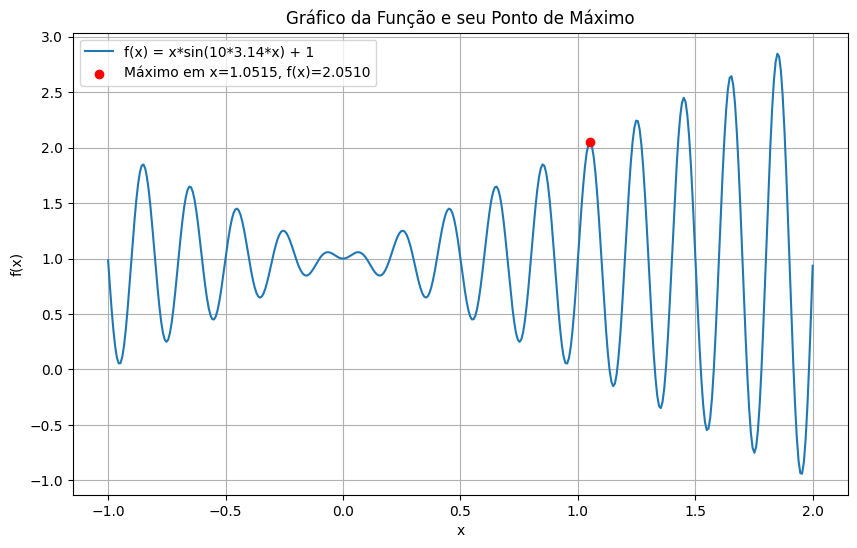

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar


def fn_objetivo(x): return x * np.sin(10 * 3.14 * x) + 1


resultado = minimize_scalar(
    lambda x: -fn_objetivo(x), bounds=(-1, 2), method='bounded')

ponto_maximo = resultado.x
valor_maximo = fn_objetivo(ponto_maximo)

x = np.linspace(-1, 2, 400)
y = fn_objetivo(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='f(x) = x*sin(10*3.14*x) + 1')
plt.scatter(ponto_maximo, valor_maximo, color='red', zorder=5,
            label=f'Máximo em x={ponto_maximo:.4f}, f(x)={valor_maximo:.4f}')

plt.title('Gráfico da Função e seu Ponto de Máximo')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

plt.show()

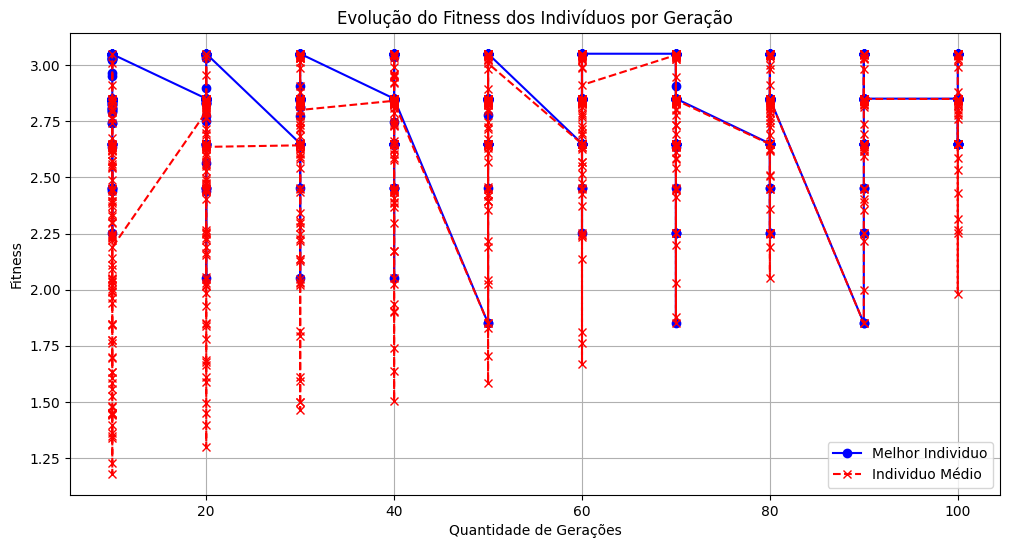

In [74]:
import matplotlib.pyplot as plt

# Adjusting the plotting code to use the correct column names
plt.figure(figsize=(12, 6))
plt.plot(df['Quantidade Gerações'], df['Best Fitness'],
         label='Melhor Individuo', marker='o', linestyle='-', color='blue')
plt.plot(df['Quantidade Gerações'], df['Average Fitness'],
         label='Individuo Médio', marker='x', linestyle='--', color='red')

plt.title('Evolução do Fitness dos Indivíduos por Geração')
plt.xlabel('Quantidade de Gerações')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()


# Problema 2

maximizar $f(x,y) = (1-x)^2 + 100(y-x^2)^2$

sujeito a:  
$(x-1)^3-y+1 \lt 0$  
$ x+y-2 \leq 0$  
$-1.5 \leq x \leq 1.5$  
$-0.5 \leq y \leq 2.5$  

## Gerando a população

In [75]:
def new_exp(quant_pais: int = 100, quant_filhos: int = 100) -> Populacao:
    return Populacao(
        quant_pais=quant_pais,
        fn_objetivo=(lambda x, y: (1-x)**2 + 100*(y-x**2)**2),
        fabric_fn_mutacao=fabric_fn_mutacao,
        quant_parametros_fn_objetivo=2,
        is_minimization=True,
        lim_inf=[-1.5, -.5],
        lim_sup=[1.5, .5],
        quant_filhos=quant_filhos,
        constrains= [(lambda x, y: ((x-1)**3 -y + 1) <= 0), (lambda x, y: (x + y - 2) <= 0)]
    )

results: List[Tuple[int, int, int, Tuple[Individuo, Individuo]]] = []
for quantidade_geracoes in range(10, 110, 10):
    for quant_pais in range(10, 110, 10):
        for quant_filhos in range(10, 110, 10):
            pop = new_exp(quant_pais, quant_filhos)  # Create the population
            # Evolve and get the best and average
            best, avg = evoluir(quantidade_geracoes, pop)
            # Append the results with the structure including the parameters
            results.append(
                (quantidade_geracoes, quant_pais, quant_filhos, (best, avg)))

## Mostrando tabela solicitada

In [76]:
from tabulate import tabulate

data = []

for entry in results:
    quantidade_geracoes, quant_pais, quant_filhos, (
        best_individuo, avg_individuo) = entry
    row = [
        quantidade_geracoes,  # Number of generations
        quant_pais,            # Number of parents
        quant_filhos,          # Number of children
        best_individuo.genotipo[0],  # list of parameters of the best individuo
        best_individuo.genotipo[1],  # list of parameters of the best individuo
        best_individuo.get_fenotipo(),  # f(x) of the best individuo
        avg_individuo.genotipo[0],   # list of parameters of the average individuo
        avg_individuo.genotipo[1],   # list of parameters of the average individuo
        avg_individuo.get_fenotipo(),   # f(x) of the average individuo
    ]
    data.append(row)

# Define headers for your new columns
headers = ["tmax", "μ", "λ", "best x", "best y",
           "best f(x,y)", "avg x","avg y", "avg f(x,y)"]

# Print the table using tabulate
table = tabulate(data, 
                 headers=headers, 
                 tablefmt="github", 
                 floatfmt=".4f"
                 )
print(table)

|   tmax |   μ |   λ |   best x |   best y |   best f(x,y) |   avg x |   avg y |   avg f(x,y) |
|--------|-----|-----|----------|----------|---------------|---------|---------|--------------|
|     10 |  10 |  10 |   0.6426 |   0.4128 |        0.1277 |  0.6568 |  0.3458 |       0.8515 |
|     10 |  10 |  20 |   0.6364 |   0.4108 |        0.1356 |  0.4332 |  0.1997 |       0.3359 |
|     10 |  10 |  30 |   0.8699 |   0.7519 |        0.0193 |  0.6857 |  0.4783 |       0.1052 |
|     10 |  10 |  40 |   0.6012 |   0.3481 |        0.1769 |  0.3292 |  0.1096 |       0.4502 |
|     10 |  10 |  50 |   0.2730 |   0.0662 |        0.5355 | -0.0626 | -0.0293 |       1.2396 |
|     10 |  10 |  60 |   0.6127 |   0.3849 |        0.1590 |  0.2993 |  0.0964 |       0.4957 |
|     10 |  10 |  70 |   0.7988 |   0.6433 |        0.0432 |  0.6408 |  0.4140 |       0.1302 |
|     10 |  10 |  80 |   0.6814 |   0.4564 |        0.1077 |  0.3852 |  0.1754 |       0.4508 |
|     10 |  10 |  90 |   0.8549 |   0.73

# Plotando

## Criando o data frame

In [77]:
import pandas as pd

data = []

for (quantidade_geracoes, quant_pais, quant_filhos, (best_individuo, avg_individuo)) in results:
    data.append({
        'Quantidade Gerações': quantidade_geracoes,
        'Quant Pais': quant_pais,
        'Quant Filhos': quant_filhos,
        # Assuming this is accessible and meaningful (e.g., a list or tuple of parameters)
        'Best Genotipo': best_individuo.genotipo,
        'Best Fitness': best_individuo.get_fenotipo(),
        # Similarly, assuming this is a list or tuple
        'Average Genotipo': avg_individuo.genotipo,
        'Average Fitness': avg_individuo.get_fenotipo()
    })

df = pd.DataFrame(data)

df[['Best x', 'Best y']] = pd.DataFrame(
    df['Best Genotipo'].tolist(), index=df.index)

df[['Avg x', 'Avg y']] = pd.DataFrame(
    df['Average Genotipo'].tolist(), index=df.index)

df.drop(['Best Genotipo', 'Average Genotipo'], axis=1, inplace=True)

# Display the first few rows to verify
print(df.head())

   Quantidade Gerações  Quant Pais  Quant Filhos  Best Fitness  \
0                   10          10            10      0.127703   
1                   10          10            20      0.135645   
2                   10          10            30      0.019259   
3                   10          10            40      0.176871   
4                   10          10            50      0.535510   

   Average Fitness    Best x    Best y     Avg x     Avg y  
0         0.851476  0.642649  0.412824  0.656832  0.345771  
1         0.335884  0.636384  0.410840  0.433178  0.199725  
2         0.105215  0.869875  0.751860  0.685736  0.478267  
3         0.450188  0.601180  0.348071  0.329159  0.109615  
4         1.239609  0.272969  0.066184 -0.062630 -0.029308  


## Plotando o gráfico

Solution: x = 0.0011, y = 0.0033
Minimum value of the objective function: 0.9989


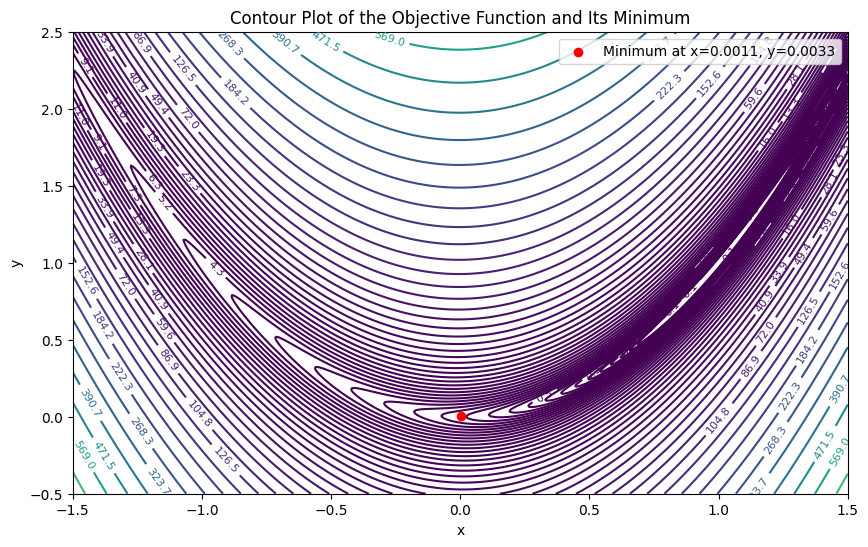

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def fn_objetivo(xy):
    x, y = xy
    return (1-x)**2 + 100*(y-x**2)**2

constraints = [
    {'type': 'ineq', 'fun': lambda xy: -((xy[0]-1)**3 - xy[1] + 1)},  # (x-1)^3 - y + 1 <= 0
    {'type': 'ineq', 'fun': lambda xy: -(xy[0] + xy[1] - 2)}  # x + y - 2 <= 0
]

bounds = [(-1.5, 1.5), (-0.5, 2.5)]

initial_guess = [0, 0]

resultado = minimize(fn_objetivo, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

solution = resultado.x
valor_minimo = resultado.fun

print(f"Solution: x = {solution[0]:.4f}, y = {solution[1]:.4f}")
print(f"Minimum value of the objective function: {valor_minimo:.4f}")

x = np.linspace(-1.5, 1.5, 400)
y = np.linspace(-0.5, 2.5, 400)
X, Y = np.meshgrid(x, y)
Z = (1-X)**2 + 100*(Y-X**2)**2

plt.figure(figsize=(10, 6))
contours = plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 50), cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)
plt.scatter(solution[0], solution[1], color='red', zorder=5, label=f"Minimum at x={solution[0]:.4f}, y={solution[1]:.4f}")
plt.title('Contour Plot of the Objective Function and Its Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


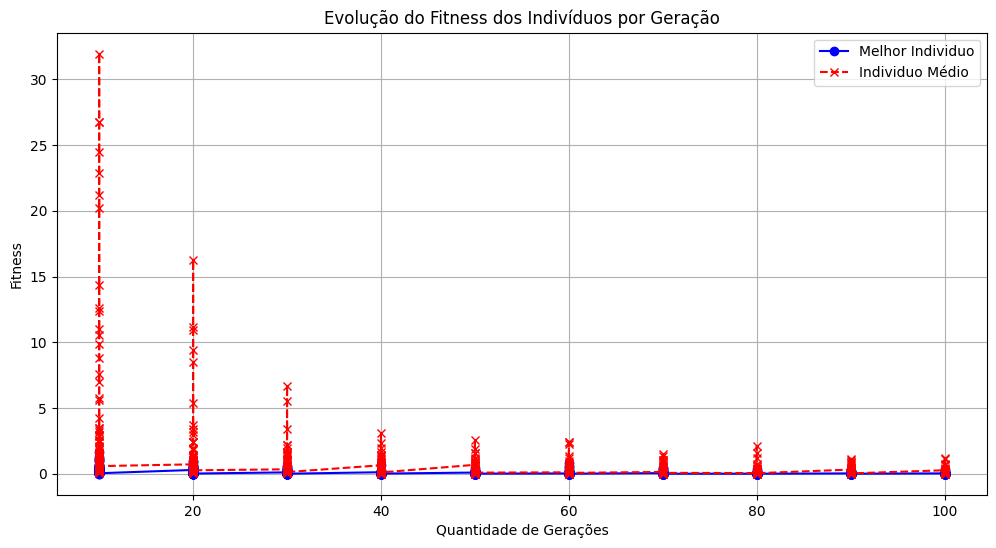

In [79]:



# Plotting the evolution of fitness values across generations
plt.figure(figsize=(12, 6))
plt.plot(df['Quantidade Gerações'], df['Best Fitness'],
         label='Melhor Individuo', marker='o', linestyle='-', color='blue')
plt.plot(df['Quantidade Gerações'], df['Average Fitness'],
         label='Individuo Médio', marker='x', linestyle='--', color='red')

plt.title('Evolução do Fitness dos Indivíduos por Geração')
plt.xlabel('Quantidade de Gerações')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()
